In [16]:
import os
import pandas as pd
import torchvision
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.segmentation as models
import torch.optim as optim
import torchvision.utils as vutils
from tqdm import tqdm
import wandb
from torchvision.models import resnet50
import csv
from PIL import Image
import numpy as np
import ast  # Import the ast module to parse the string representation of lists

## Data Loader

In [17]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, sketch_dir, label_csv, random_label_csv):
        self.image_dir = image_dir
        self.sketch_dir = sketch_dir
        self.labels = pd.read_csv(label_csv)
        self.random_labels = pd.read_csv(random_label_csv)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0] + '.jpg')
        sketch_name = os.path.join(self.sketch_dir, self.labels.iloc[idx, 0] + '_segmentation.png')
        image = Image.open(img_name).convert('RGB')
        sketch = Image.open(sketch_name).convert('L')  # Convert to grayscale

        # Get true label for the images
        true_label = torch.tensor(self.labels.iloc[idx, 1:], dtype=torch.float32)
        random_row = self.random_labels.iloc[:, 1:].sample(n=1, random_state=random.randint(0, 9000))
        random_label = torch.tensor(random_row.values[0], dtype=torch.float32)


        transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images
            transforms.ToTensor(),  # Convert images to PyTorch tensors
        ])

        image = transform(image)
        sketch = transform(sketch)

        return image, sketch, true_label, random_label, img_name, sketch_name

# Paths for train data
train_image_folder = '/teamspace/studios/this_studio/Dataset/Train_data'
train_sketch_folder = '/teamspace/studios/this_studio/Dataset/Train/Paired_train_sketches'
train_label_csv = '/teamspace/studios/this_studio/Dataset/Train/Train_labels.csv'
train_random_label_csv = train_label_csv

# Paths for test data
test_image_folder = '/teamspace/studios/this_studio/Dataset/Test/Test_data'
test_sketch_folder = '/teamspace/studios/this_studio/Dataset/Test/Paired_test_sketch'
test_label_csv = '/teamspace/studios/this_studio/Dataset/Test/Test_labels.csv'
test_random_label_csv = test_label_csv 

# Create a CustomDataset instance for the train and test dataset
train_dataset = CustomDataset(train_image_folder, train_sketch_folder, train_label_csv, train_random_label_csv)
test_dataset = CustomDataset(test_image_folder, test_sketch_folder, test_label_csv, test_random_label_csv)

# Create DataLoader instances for both training and test datasets
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
for image, sketch, true_label, random_label, img_name, sketch_name in train_data_loader:
    print("Sketch Image shape:", sketch.shape)
    print("Real Image shape:", image.shape)
    print("True Label shape:", true_label.shape)
    print("Random Label shape:", random_label.shape)
    break

/tmp/ipykernel_7689/2392190678.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = torch.tensor(self.labels.iloc[idx, 1:], dtype=torch.float32)


Sketch Image shape: torch.Size([32, 1, 64, 64])
Real Image shape: torch.Size([32, 3, 64, 64])
True Label shape: torch.Size([32, 7])
Random Label shape: torch.Size([32, 7])


## Visualization

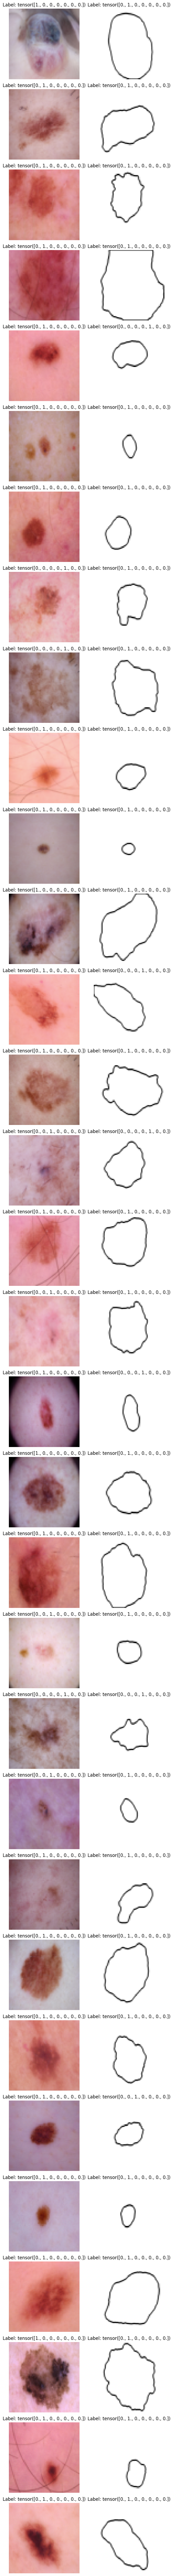

In [ ]:
def plot_batch(batch_images, batch_sketches, batch_image_labels, batch_sketch_labels):
    batch_size = len(batch_images)
    fig, axs = plt.subplots(batch_size, 2, figsize=(7, 3 * batch_size))  # Adjusted figsize here

    for i in range(batch_size):
        # Plotting image with label
        image = batch_images[i].permute(1, 2, 0).numpy()
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Label: {batch_image_labels[i]}')
        axs[i, 0].axis('off')

        # Plotting sketch with label
        sketch = batch_sketches[i].squeeze().numpy()
        axs[i, 1].imshow(sketch, cmap='gray')
        axs[i, 1].set_title(f'Label: {batch_sketch_labels[i]}')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

for image, sketch, true_label, random_labels, img_name, sketch_name in train_data_loader:
    plot_batch(image, sketch, true_label, random_labels)
    break


## Model Architecture

In [19]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [20]:
class Generator(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(Generator, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(128, 256)
        self.down2 = Down(256, 512)
        self.down3 = Down(512, 1024)
        factor = 2 if bilinear else 1
        self.down4 = Down(1024, 2048 // factor)
        self.up1 = Up(2048, 1024 // factor, bilinear)
        self.up2 = Up(1024, 512 // factor, bilinear)
        self.up3 = Up(512, 256 // factor, bilinear)
        self.up4 = Up(256, 64, bilinear)
        self.outc = OutConv(64, 3)
        self.label_embedding = nn.Embedding(7, 7)

    def forward(self, x, label):
        label = label.long()
        label_embedding = self.label_embedding(label)
        label_embedding = label_embedding.unsqueeze(1)  # Expand dimensions to match spatial size
        label_embedding = F.interpolate(label_embedding, size=(64, 64), mode='nearest')
        label_embedding = label_embedding.repeat(1, 64, 1, 1)  # label_embedding shape torch.Size([32, 64, 64, 64])
        x1 = self.inc(x)
        x1 = torch.cat((x1, label_embedding), dim=1)  # Concatenate with label embedding
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Upsampling and concatenating with label embedding
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # x = self.up5(x, x1)
        logits = self.outc(x)
        return logits

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
        )

        self.layer_1 = nn.Linear(12593, 256)
        self.layer_1_b = nn.BatchNorm1d(256)
        self.layer_1_a = nn.LeakyReLU()

        self.layer_2 = nn.Linear(256, 128)
        self.layer_2_b = nn.BatchNorm1d(128)
        self.layer_2_a = nn.LeakyReLU()

        self.layer_3 = nn.Linear(128, 1)
        self.layer_3_a = nn.Sigmoid()

        self.label_embedding = nn.Embedding(7, 7)


    def forward(self, x, label):
        label = label.long()
        label_embedding = self.label_embedding(label)
        label_embedding = label_embedding.unsqueeze(1)

        x = self.disc_model(x)
        x = torch.cat([x, label_embedding], 1)
        x = torch.flatten(x, start_dim=1)
        x = self.layer_1_a(self.layer_1_b(self.layer_1(x)))
        x = self.layer_2_a(self.layer_2_b(self.layer_2(x)))
        x = self.layer_3_a(self.layer_3(x))
        return x

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [23]:
n_channels = 1  # Number of input channels
n_classes = 7  # Number of output channels
bilinear = True  # Use bilinear interpolation for upsampling

generator = Generator(n_channels, n_classes, bilinear).to(device)
discriminator = Discriminator().to(device)

## wanddb Training Loop

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vamsi8106 (vamsi_8106). Use `wandb login --relogin` to force relogin


/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 1/282 [00:03<17:23,  3.71s/it]

[Epoch 0/100] [Batch 0/282] [D loss: 0.721726] [G loss: 80.929161]


  0%|          | 1/282 [00:00<03:15,  1.44it/s]

[Epoch 1/100] [Batch 0/282] [D loss: 0.707146] [G loss: 11.189615]


  0%|          | 1/282 [00:00<03:26,  1.36it/s]

[Epoch 2/100] [Batch 0/282] [D loss: 0.689073] [G loss: 8.660151]


  0%|          | 1/282 [00:00<03:27,  1.35it/s]

[Epoch 3/100] [Batch 0/282] [D loss: 0.677854] [G loss: 9.610191]


  0%|          | 1/282 [00:00<03:11,  1.46it/s]

[Epoch 4/100] [Batch 0/282] [D loss: 0.658916] [G loss: 9.644266]


  0%|          | 1/282 [00:00<03:29,  1.34it/s]

[Epoch 5/100] [Batch 0/282] [D loss: 0.655766] [G loss: 9.207804]


  0%|          | 1/282 [00:00<03:13,  1.45it/s]

[Epoch 6/100] [Batch 0/282] [D loss: 0.635184] [G loss: 8.836640]


  0%|          | 1/282 [00:00<03:18,  1.42it/s]

[Epoch 7/100] [Batch 0/282] [D loss: 0.646983] [G loss: 8.384020]


  0%|          | 1/282 [00:00<03:20,  1.40it/s]

[Epoch 8/100] [Batch 0/282] [D loss: 0.660891] [G loss: 8.319109]


  0%|          | 1/282 [00:00<03:16,  1.43it/s]

[Epoch 9/100] [Batch 0/282] [D loss: 0.617668] [G loss: 9.670812]


  0%|          | 1/282 [00:00<03:40,  1.27it/s]

[Epoch 10/100] [Batch 0/282] [D loss: 0.633606] [G loss: 9.072090]


  0%|          | 1/282 [00:00<03:16,  1.43it/s]

[Epoch 11/100] [Batch 0/282] [D loss: 0.679550] [G loss: 8.236101]


  0%|          | 1/282 [00:00<03:20,  1.40it/s]

[Epoch 12/100] [Batch 0/282] [D loss: 0.619627] [G loss: 8.495491]


  0%|          | 1/282 [00:00<03:28,  1.35it/s]

[Epoch 13/100] [Batch 0/282] [D loss: 0.718239] [G loss: 8.151495]


  0%|          | 1/282 [00:00<03:22,  1.39it/s]

[Epoch 14/100] [Batch 0/282] [D loss: 0.620038] [G loss: 7.927154]


  0%|          | 1/282 [00:00<03:23,  1.38it/s]

[Epoch 15/100] [Batch 0/282] [D loss: 0.623773] [G loss: 7.761962]


  0%|          | 1/282 [00:00<03:21,  1.39it/s]

[Epoch 16/100] [Batch 0/282] [D loss: 0.643966] [G loss: 6.809115]


  0%|          | 1/282 [00:00<03:27,  1.35it/s]

[Epoch 17/100] [Batch 0/282] [D loss: 0.616290] [G loss: 7.351173]


  0%|          | 1/282 [00:00<03:38,  1.29it/s]

[Epoch 18/100] [Batch 0/282] [D loss: 0.652862] [G loss: 6.318815]


  0%|          | 1/282 [00:00<03:32,  1.32it/s]

[Epoch 19/100] [Batch 0/282] [D loss: 0.698092] [G loss: 6.703753]


  0%|          | 1/282 [00:00<03:31,  1.33it/s]

[Epoch 20/100] [Batch 0/282] [D loss: 0.586057] [G loss: 6.432973]


  0%|          | 1/282 [00:00<03:30,  1.33it/s]

[Epoch 21/100] [Batch 0/282] [D loss: 0.651727] [G loss: 5.704284]


  0%|          | 1/282 [00:00<03:28,  1.35it/s]

[Epoch 22/100] [Batch 0/282] [D loss: 0.643691] [G loss: 6.188383]


  0%|          | 1/282 [00:00<03:26,  1.36it/s]

[Epoch 23/100] [Batch 0/282] [D loss: 0.600554] [G loss: 5.592828]


  0%|          | 1/282 [00:00<03:20,  1.40it/s]

[Epoch 24/100] [Batch 0/282] [D loss: 0.607232] [G loss: 5.918243]


  0%|          | 1/282 [00:00<03:19,  1.41it/s]

[Epoch 25/100] [Batch 0/282] [D loss: 0.597302] [G loss: 5.599051]


  0%|          | 1/282 [00:00<03:32,  1.32it/s]

[Epoch 26/100] [Batch 0/282] [D loss: 0.596386] [G loss: 5.289261]


  0%|          | 1/282 [00:00<03:47,  1.23it/s]

[Epoch 27/100] [Batch 0/282] [D loss: 0.619764] [G loss: 5.481368]


  0%|          | 1/282 [00:00<03:19,  1.41it/s]

[Epoch 28/100] [Batch 0/282] [D loss: 0.602899] [G loss: 5.104318]


  0%|          | 1/282 [00:00<03:24,  1.37it/s]

[Epoch 29/100] [Batch 0/282] [D loss: 0.587696] [G loss: 4.985468]


  0%|          | 1/282 [00:00<03:28,  1.35it/s]

[Epoch 30/100] [Batch 0/282] [D loss: 0.594491] [G loss: 5.379859]


  0%|          | 1/282 [00:00<03:29,  1.34it/s]

[Epoch 31/100] [Batch 0/282] [D loss: 0.572961] [G loss: 5.342262]


  0%|          | 1/282 [00:00<03:21,  1.40it/s]

[Epoch 32/100] [Batch 0/282] [D loss: 0.577903] [G loss: 5.020345]


  0%|          | 1/282 [00:00<03:35,  1.30it/s]

[Epoch 33/100] [Batch 0/282] [D loss: 0.561551] [G loss: 5.546621]


  0%|          | 1/282 [00:00<03:16,  1.43it/s]

[Epoch 34/100] [Batch 0/282] [D loss: 0.559732] [G loss: 5.267407]


  0%|          | 1/282 [00:00<03:19,  1.41it/s]

[Epoch 35/100] [Batch 0/282] [D loss: 0.567417] [G loss: 4.650692]


  0%|          | 1/282 [00:00<03:17,  1.42it/s]

[Epoch 36/100] [Batch 0/282] [D loss: 0.557054] [G loss: 4.808052]


  0%|          | 1/282 [00:00<03:06,  1.50it/s]

[Epoch 37/100] [Batch 0/282] [D loss: 0.766918] [G loss: 4.137846]


  0%|          | 1/282 [00:00<03:07,  1.50it/s]

[Epoch 38/100] [Batch 0/282] [D loss: 0.563712] [G loss: 4.993652]


  0%|          | 1/282 [00:00<03:03,  1.53it/s]

[Epoch 39/100] [Batch 0/282] [D loss: 0.656028] [G loss: 4.557917]


  0%|          | 1/282 [00:00<03:06,  1.51it/s]

[Epoch 40/100] [Batch 0/282] [D loss: 0.639758] [G loss: 4.539682]


  0%|          | 1/282 [00:00<03:07,  1.50it/s]

[Epoch 41/100] [Batch 0/282] [D loss: 0.569278] [G loss: 4.209545]


  0%|          | 1/282 [00:00<03:03,  1.53it/s]

[Epoch 42/100] [Batch 0/282] [D loss: 0.618328] [G loss: 4.234907]


  0%|          | 1/282 [00:00<03:35,  1.31it/s]

[Epoch 43/100] [Batch 0/282] [D loss: 0.587560] [G loss: 4.206148]


  0%|          | 1/282 [00:00<03:04,  1.53it/s]

[Epoch 44/100] [Batch 0/282] [D loss: 0.570612] [G loss: 4.370140]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 45/100] [Batch 0/282] [D loss: 0.593812] [G loss: 4.574032]


  0%|          | 1/282 [00:00<03:18,  1.41it/s]

[Epoch 46/100] [Batch 0/282] [D loss: 0.564674] [G loss: 4.993399]


  0%|          | 1/282 [00:00<03:17,  1.43it/s]

[Epoch 47/100] [Batch 0/282] [D loss: 0.552607] [G loss: 4.051013]


  0%|          | 1/282 [00:00<03:22,  1.39it/s]

[Epoch 48/100] [Batch 0/282] [D loss: 0.634487] [G loss: 3.986852]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 49/100] [Batch 0/282] [D loss: 0.548628] [G loss: 4.085492]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 50/100] [Batch 0/282] [D loss: 0.544399] [G loss: 4.967891]


  0%|          | 1/282 [00:00<03:09,  1.48it/s]

[Epoch 51/100] [Batch 0/282] [D loss: 0.555697] [G loss: 3.967328]


  0%|          | 1/282 [00:00<03:13,  1.45it/s]

[Epoch 52/100] [Batch 0/282] [D loss: 0.562990] [G loss: 3.669483]


  0%|          | 1/282 [00:00<03:04,  1.52it/s]

[Epoch 53/100] [Batch 0/282] [D loss: 0.560990] [G loss: 4.080739]


  0%|          | 1/282 [00:00<03:10,  1.47it/s]

[Epoch 54/100] [Batch 0/282] [D loss: 0.546284] [G loss: 3.882321]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 55/100] [Batch 0/282] [D loss: 0.548489] [G loss: 3.744344]


  0%|          | 1/282 [00:00<03:05,  1.51it/s]

[Epoch 56/100] [Batch 0/282] [D loss: 0.550152] [G loss: 4.142554]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 57/100] [Batch 0/282] [D loss: 0.546267] [G loss: 3.743724]


  0%|          | 1/282 [00:00<03:19,  1.41it/s]

[Epoch 58/100] [Batch 0/282] [D loss: 0.545088] [G loss: 4.063098]


  0%|          | 1/282 [00:00<03:06,  1.51it/s]

[Epoch 59/100] [Batch 0/282] [D loss: 0.539733] [G loss: 3.552997]


  0%|          | 1/282 [00:00<03:03,  1.54it/s]

[Epoch 60/100] [Batch 0/282] [D loss: 0.540244] [G loss: 3.542346]


  0%|          | 1/282 [00:00<03:19,  1.41it/s]

[Epoch 61/100] [Batch 0/282] [D loss: 0.533186] [G loss: 3.683582]


  0%|          | 1/282 [00:00<03:09,  1.49it/s]

[Epoch 62/100] [Batch 0/282] [D loss: 0.537501] [G loss: 3.757554]


  0%|          | 1/282 [00:00<03:03,  1.53it/s]

[Epoch 63/100] [Batch 0/282] [D loss: 0.531157] [G loss: 3.652626]


  0%|          | 1/282 [00:00<03:05,  1.51it/s]

[Epoch 64/100] [Batch 0/282] [D loss: 0.549237] [G loss: 3.323482]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 65/100] [Batch 0/282] [D loss: 0.531808] [G loss: 3.753873]


  0%|          | 1/282 [00:00<03:06,  1.50it/s]

[Epoch 66/100] [Batch 0/282] [D loss: 0.550282] [G loss: 3.658533]


  0%|          | 1/282 [00:00<03:06,  1.51it/s]

[Epoch 67/100] [Batch 0/282] [D loss: 0.537576] [G loss: 3.549617]


  0%|          | 1/282 [00:00<03:17,  1.43it/s]

[Epoch 68/100] [Batch 0/282] [D loss: 0.534687] [G loss: 4.223225]


  0%|          | 1/282 [00:00<03:07,  1.50it/s]

[Epoch 69/100] [Batch 0/282] [D loss: 0.528368] [G loss: 3.845649]


  0%|          | 1/282 [00:00<03:09,  1.48it/s]

[Epoch 70/100] [Batch 0/282] [D loss: 0.533433] [G loss: 3.514901]


  0%|          | 1/282 [00:00<03:09,  1.48it/s]

[Epoch 71/100] [Batch 0/282] [D loss: 0.756952] [G loss: 3.049612]


  0%|          | 1/282 [00:00<03:06,  1.50it/s]

[Epoch 72/100] [Batch 0/282] [D loss: 0.534110] [G loss: 3.481872]


  0%|          | 1/282 [00:00<03:10,  1.47it/s]

[Epoch 73/100] [Batch 0/282] [D loss: 0.536540] [G loss: 3.826724]


  0%|          | 1/282 [00:00<03:02,  1.54it/s]

[Epoch 74/100] [Batch 0/282] [D loss: 0.541166] [G loss: 3.453826]


  0%|          | 1/282 [00:00<03:09,  1.49it/s]

[Epoch 75/100] [Batch 0/282] [D loss: 0.533324] [G loss: 3.499716]


  0%|          | 1/282 [00:00<03:07,  1.50it/s]

[Epoch 76/100] [Batch 0/282] [D loss: 0.532803] [G loss: 3.461050]


  0%|          | 1/282 [00:00<03:06,  1.51it/s]

[Epoch 77/100] [Batch 0/282] [D loss: 0.528620] [G loss: 3.766226]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 78/100] [Batch 0/282] [D loss: 0.524204] [G loss: 3.353687]


  0%|          | 1/282 [00:00<03:26,  1.36it/s]

[Epoch 79/100] [Batch 0/282] [D loss: 0.526929] [G loss: 3.192394]


  0%|          | 1/282 [00:00<03:04,  1.52it/s]

[Epoch 80/100] [Batch 0/282] [D loss: 0.536648] [G loss: 3.257989]


  0%|          | 1/282 [00:00<03:09,  1.48it/s]

[Epoch 81/100] [Batch 0/282] [D loss: 0.527206] [G loss: 3.776381]


  0%|          | 1/282 [00:00<03:09,  1.49it/s]

[Epoch 82/100] [Batch 0/282] [D loss: 0.528548] [G loss: 3.106414]


  0%|          | 1/282 [00:00<03:04,  1.53it/s]

[Epoch 83/100] [Batch 0/282] [D loss: 0.553775] [G loss: 3.262787]


  0%|          | 1/282 [00:00<03:09,  1.49it/s]

[Epoch 84/100] [Batch 0/282] [D loss: 0.533877] [G loss: 3.225996]


  0%|          | 1/282 [00:00<03:10,  1.47it/s]

[Epoch 85/100] [Batch 0/282] [D loss: 0.523732] [G loss: 3.266018]


  0%|          | 1/282 [00:00<03:05,  1.51it/s]

[Epoch 86/100] [Batch 0/282] [D loss: 0.536069] [G loss: 3.318429]


  0%|          | 1/282 [00:00<03:17,  1.42it/s]

[Epoch 87/100] [Batch 0/282] [D loss: 0.517819] [G loss: 3.276590]


  0%|          | 1/282 [00:00<03:06,  1.50it/s]

[Epoch 88/100] [Batch 0/282] [D loss: 0.530477] [G loss: 3.147147]


  0%|          | 1/282 [00:00<03:07,  1.50it/s]

[Epoch 89/100] [Batch 0/282] [D loss: 0.537920] [G loss: 3.070218]


  0%|          | 1/282 [00:00<03:07,  1.50it/s]

[Epoch 90/100] [Batch 0/282] [D loss: 0.528398] [G loss: 3.112766]


  0%|          | 1/282 [00:00<03:06,  1.51it/s]

[Epoch 91/100] [Batch 0/282] [D loss: 0.524800] [G loss: 3.081769]


  0%|          | 1/282 [00:00<03:04,  1.52it/s]

[Epoch 92/100] [Batch 0/282] [D loss: 0.543346] [G loss: 2.785730]


  0%|          | 1/282 [00:00<03:04,  1.52it/s]

[Epoch 93/100] [Batch 0/282] [D loss: 0.517231] [G loss: 3.071584]


  0%|          | 1/282 [00:00<03:06,  1.51it/s]

[Epoch 94/100] [Batch 0/282] [D loss: 0.525738] [G loss: 2.890738]


  0%|          | 1/282 [00:00<03:07,  1.50it/s]

[Epoch 95/100] [Batch 0/282] [D loss: 0.635532] [G loss: 3.303916]


  0%|          | 1/282 [00:00<03:05,  1.52it/s]

[Epoch 96/100] [Batch 0/282] [D loss: 0.521170] [G loss: 3.331864]


  0%|          | 1/282 [00:00<03:24,  1.37it/s]

[Epoch 97/100] [Batch 0/282] [D loss: 0.519703] [G loss: 3.421492]


  0%|          | 1/282 [00:00<03:08,  1.49it/s]

[Epoch 98/100] [Batch 0/282] [D loss: 0.526231] [G loss: 3.203464]


  0%|          | 1/282 [00:00<03:21,  1.40it/s]

[Epoch 99/100] [Batch 0/282] [D loss: 0.527977] [G loss: 3.160284]


100%|██████████| 282/282 [03:05<00:00,  1.52it/s]
wandb: Network error (SSLError), entering retry loop.


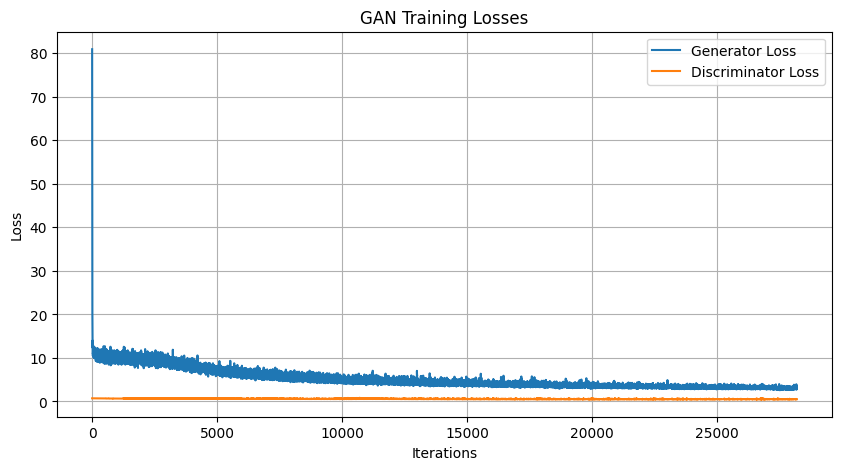

In [ ]:
# Initialize W&B run
wandb.init(project="Conditional_GAN", name="GAN_training")

# Set directory to save images and best model
save_dir_images = "Images_Generated_3"
save_dir_best_model = "Images_Generated_3"

os.makedirs(save_dir_images, exist_ok=True)
os.makedirs(save_dir_best_model, exist_ok=True)

# Define loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
pixelwise_loss = nn.L1Loss()

# Define additional parameters
lambda_pixel = 100  # Weight for pixelwise loss
lambda_gp = 10      # Weight for gradient penalty
lambda_perceptual = 0.1  # Weight for perceptual loss

# Settingup Optimizers
optimizer_G = optim.SGD(generator.parameters(), lr=0.0002, momentum=0.9)
optimizer_D = optim.SGD(discriminator.parameters(), lr=0.0002, momentum=0.9)

# Lists to store losses
G_losses = []
D_losses = []

# Pre-trained VGG model for perceptual loss
vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
vgg.eval()

# Training Loop
num_epochs = 100

# Initialize variables to keep track of the best loss and corresponding model state
best_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    for i, (real_images, sketches, true_label, random_label_onehot, img_name, sketch_name) in enumerate(tqdm(train_data_loader)):
        batch_size = true_label.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        random_label_onehot= random_label_onehot.cuda()
        true_label = true_label.cuda()
        sketches = sketches.cuda()
        real_images = real_images.cuda()

        # Train Generator
        optimizer_G.zero_grad()

        generated_images = generator(sketches, random_label_onehot)
        validity = discriminator(generated_images, random_label_onehot)
        g_loss_adv = adversarial_loss(validity, valid)

        g_loss_pixel = pixelwise_loss(generated_images, real_images)

        real_features = vgg(real_images)
        fake_features = vgg(generated_images)
        g_loss_perceptual = sum(torch.mean((rf - ff) ** 2) for rf, ff in zip(real_features, fake_features))

        g_loss = g_loss_adv + lambda_pixel * g_loss_pixel + lambda_perceptual * g_loss_perceptual

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        real_pred = discriminator(real_images, true_label)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(generated_images.detach(),random_label_onehot)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss)/2

        d_loss.backward()
        optimizer_D.step()

        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Log losses to W&B
        wandb.log({"G_loss": g_loss.item(), "D_loss": d_loss.item()})

        # Print some statistics
        if i % 300 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, num_epochs, i, len(train_data_loader), d_loss.item(), g_loss.item())
            )

    # Saving generated images after each epoch
    with torch.no_grad():
        fake_images = generator(sketches, random_label_onehot).detach().cpu()
        vutils.save_image(fake_images, os.path.join(save_dir_images, f"generated_images_epoch_{epoch}.png"), normalize=True)

    # Checking if current epoch has better loss than the best loss
    if g_loss < best_loss:
        best_loss = g_loss
        best_model_state = generator.state_dict()

    # Saving generated images and real images side by side in a single image
    with torch.no_grad():
        fake_images = generator(sketches, random_label_onehot).detach().cpu()
        real_images = real_images.cpu()

        combined_images = torch.cat((real_images, fake_images), dim=3)

        vutils.save_image(combined_images, os.path.join(save_dir_images, f"combined_images_epoch_{epoch}.png"), normalize=True)
    # Saving the best model state to a folder
    torch.save(best_model_state, os.path.join(save_dir_best_model, 'best_model.pth'))


plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir_images, "loss_curves.png"))

# Log loss curves to W&B
wandb.log({"loss_curves": wandb.Image(os.path.join(save_dir_images, "loss_curves.png"))})


## Classifier

In [ ]:
# Load pre-trained ResNet model
classifier = resnet50(pretrained=True).to(device)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 7).to(device)  # Assuming 7 classes

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001)  # Set a small learning rate

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, true_label = torch.max(labels, 1)
    correct = (predicted == true_label).sum().item()
    total = labels.size(0)
    return correct / total

# Training the classifier
num_epochs = 20
train_losses = []
train_accuracies = []
best_loss = float('inf')
early_stop_count = 0
patience = 3 # Number of epochs to wait before early stopping

for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for i, (images, sketch, true_label, random_label, img_name, sketch_name) in enumerate(tqdm(train_data_loader)):
        images, true_label = images.to(device), true_label.to(device)

        # Forward pass
        outputs = classifier(images)
        loss = criterion(outputs, true_label)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total_correct += calculate_accuracy(outputs, true_label) * images.size(0)
        total_samples += images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = total_correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("Early stopping triggered.")
            break

# Save the trained classifier
torch.save(classifier.state_dict(), 'trained_classifier.pth')

/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 282/282 [02:28<00:00,  1.90it/s]


Epoch [1/20], Loss: 0.3402, Accuracy: 0.6588


100%|██████████| 282/282 [02:27<00:00,  1.91it/s]


Epoch [2/20], Loss: 0.2406, Accuracy: 0.6801


100%|██████████| 282/282 [02:26<00:00,  1.92it/s]


Epoch [3/20], Loss: 0.2208, Accuracy: 0.6806


100%|██████████| 282/282 [02:26<00:00,  1.92it/s]


Epoch [4/20], Loss: 0.2087, Accuracy: 0.6831


100%|██████████| 282/282 [02:27<00:00,  1.91it/s]


Epoch [5/20], Loss: 0.1998, Accuracy: 0.6885


100%|██████████| 282/282 [02:28<00:00,  1.89it/s]


Epoch [6/20], Loss: 0.1929, Accuracy: 0.6994


100%|██████████| 282/282 [02:26<00:00,  1.92it/s]


Epoch [7/20], Loss: 0.1881, Accuracy: 0.7050


100%|██████████| 282/282 [02:29<00:00,  1.89it/s]


Epoch [8/20], Loss: 0.1830, Accuracy: 0.7108


100%|██████████| 282/282 [02:28<00:00,  1.90it/s]


Epoch [9/20], Loss: 0.1790, Accuracy: 0.7150


100%|██████████| 282/282 [02:28<00:00,  1.90it/s]


Epoch [10/20], Loss: 0.1750, Accuracy: 0.7194


100%|██████████| 282/282 [02:27<00:00,  1.91it/s]


Epoch [11/20], Loss: 0.1712, Accuracy: 0.7241


100%|██████████| 282/282 [02:27<00:00,  1.91it/s]


Epoch [12/20], Loss: 0.1675, Accuracy: 0.7336


100%|██████████| 282/282 [02:28<00:00,  1.90it/s]


Epoch [13/20], Loss: 0.1646, Accuracy: 0.7337


100%|██████████| 282/282 [02:27<00:00,  1.91it/s]


Epoch [14/20], Loss: 0.1616, Accuracy: 0.7392


100%|██████████| 282/282 [02:27<00:00,  1.91it/s]


Epoch [15/20], Loss: 0.1594, Accuracy: 0.7456


100%|██████████| 282/282 [02:26<00:00,  1.92it/s]


Epoch [16/20], Loss: 0.1560, Accuracy: 0.7500


100%|██████████| 282/282 [02:27<00:00,  1.92it/s]


Epoch [17/20], Loss: 0.1533, Accuracy: 0.7522


100%|██████████| 282/282 [02:26<00:00,  1.92it/s]


Epoch [18/20], Loss: 0.1500, Accuracy: 0.7594


100%|██████████| 282/282 [02:26<00:00,  1.93it/s]


Epoch [19/20], Loss: 0.1478, Accuracy: 0.7655


100%|██████████| 282/282 [02:27<00:00,  1.91it/s]


Epoch [20/20], Loss: 0.1450, Accuracy: 0.7736


The same above Model is trained for 100 epochs in another and that modle has been loaded and used for further evaluation

In [ ]:
classifier = resnet50(pretrained=False).to(device)  # Initialize a new instance without pretrained weights
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 7).to(device)

# Load the saved model weights
saved_model_path = 'trained_classifier_1.pth'
classifier.load_state_dict(torch.load(saved_model_path))
classifier.eval()

/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Generated Images as Test Images for Classification

In [10]:
n_channels = 1  # Number of input channels
n_classes = 7  # Number of output channels
bilinear = True  # Use bilinear interpolation for upsampling
generator = Generator(n_channels, n_classes, bilinear).to(device)

# Load the model checkpoint
checkpoint = torch.load('/teamspace/studios/this_studio/best_model(1).pth')

# Load the state dictionary of the generator
generator.load_state_dict(checkpoint)

# Set the generator to evaluation mode
generator.eval()


Generator(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [ ]:
# Creating a directory to save generated images
output_dir = "generated_images_per_class"
os.makedirs(output_dir, exist_ok=True)

num_classes = 7
num_images_per_class = 10

# Creating directories for each class if they don't exist
for class_index in range(num_classes):
    class_dir = os.path.join(output_dir, f"class_{class_index}")
    os.makedirs(class_dir, exist_ok=True)

# Creating a CSV file to save image paths and labels
csv_file = "generated_images_labels.csv"
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Image_Path", "Label"])

# Dictionary to keep track of the number of images generated for each class
num_images_generated = {i: 0 for i in range(num_classes)}

# Loop through the test dataset until each class has ten images
while not all(num_images_generated[class_index] >= num_images_per_class for class_index in range(num_classes)):
    for image, sketches, true_labels, random_label, img_name, sketch_name in test_data_loader:
        sketches = sketches.to(device)
        true_labels = true_labels.to(device)

        # Generate images from sketches and true labels
        generated_batch = generator(sketches, true_labels)

        # Iterate through the batch
        for i in range(sketches.size(0)):
            class_index = torch.argmax(true_labels[i]).item()

            # Check if we have generated enough images for this class
            if num_images_generated[class_index] < num_images_per_class:
                generated_image = generated_batch[i].detach().cpu()
                image_path = os.path.join(output_dir, f"class_{class_index}", f"image_{num_images_generated[class_index]}.png")
                vutils.save_image(generated_image, image_path, normalize=True)
                num_images_generated[class_index] += 1

                # Append the image path and label to the CSV file
                with open(csv_file, "a", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow([image_path, true_labels[i].tolist()])

        # Check if we have generated enough images for each class
        if all(num_images_generated[class_index] >= num_images_per_class for class_index in range(num_classes)):
            break

print("CSV file saved successfully.")

CSV file saved successfully.


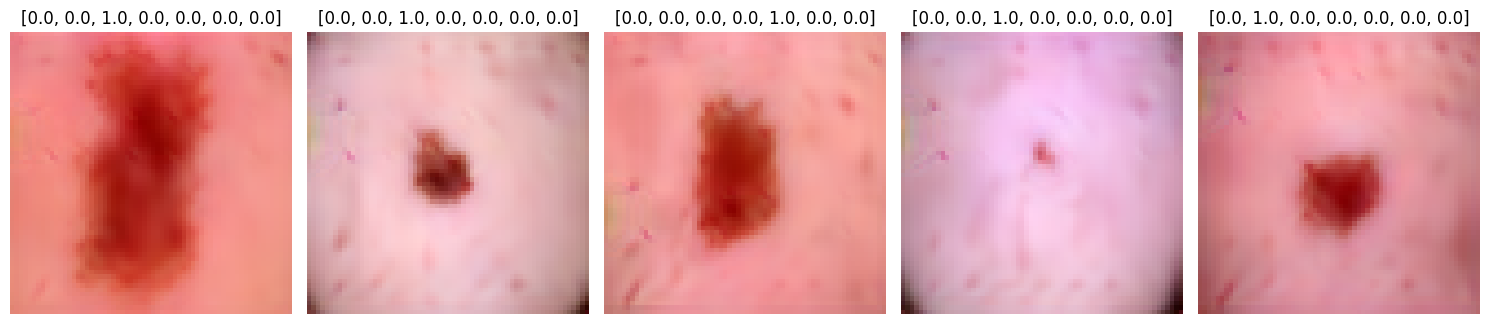

In [ ]:
# Load the CSV file containing image paths and labels
df = pd.read_csv("generated_images_labels.csv")

# Randomly select five images
sample_df = df.sample(n=5)

# Plot the images along with their labels
plt.figure(figsize=(15, 8))
for i, (_, row) in enumerate(sample_df.iterrows()):
    image = plt.imread(row["Image_Path"])
    label = row["Label"]

    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Load the saved images and their corresponding labels from the CSV file
image_paths = []
labels = []
with open("generated_images_labels.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        image_paths.append(row[0])
        labels.append(ast.literal_eval(row[1]))

# Defining the preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

all_predictions = []
all_targets = []

# Loop through images and predict labels
for image_path, label in zip(image_paths, labels):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0).to(device) # Add batch dimension

    with torch.no_grad():
        output = classifier(image)

    # Convert the output to predicted class
    predicted_class = torch.argmax(output, dim=1).item()

    # Convert label to class index
    true_class = torch.argmax(torch.tensor(label)).item()

    # Append the prediction and target label to lists
    all_predictions.append(predicted_class)
    all_targets.append(true_class)

# Convert predictions and targets to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate accuracy
accuracy = (all_predictions == all_targets).mean()
print(f"Accuracy: {accuracy}")


Accuracy: 0.15714285714285714


In [ ]:
print(output)
predicted_class = torch.argmax(output, dim=1).item()
print(predicted_class)

tensor([[ 0.5417, -2.2796, -3.0307, -2.6478, -2.0301, -3.3571, -3.9843]],
       device='cuda:0')
0


In [ ]:
print(all_predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0]


In [ ]:
print(all_targets)

[4 4 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 6 2 3 4 0 2 0 0 2 4 4 4 4 4 4 4 3 5
 6 3 6 2 2 3 2 2 3 3 2 5 6 2 2 6 6 5 5 5 3 6 6 5 5 5 5 3 6 6 5 3 3]


In [ ]:
print(all_targets.dtype)
print(all_predictions.dtype)

int64
int64


In [ ]:
import csv
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import ast  # Import the ast module to parse the string representation of lists

# Load the saved images and their corresponding labels from the CSV file
image_paths = []
labels = []
with open("generated_images_labels.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        image_paths.append(row[0])
        labels.append(ast.literal_eval(row[1]))  # Parse the string representation of list to actual list of floats

# Define any preprocessing transformations if needed
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to match the input size of the classifier
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Initialize lists to store predictions and targets
all_predictions = []
all_targets = []

# Initialize dictionaries to store class-wise correct predictions and total samples
classwise_correct = {}
classwise_total = {}

# Loop through images and predict labels
for image_path, label in zip(image_paths, labels):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Pass the image through the classifier
    with torch.no_grad():
        output = classifier(image)

    # Convert the output to predicted class
    predicted_class = torch.argmax(output, dim=1).item()

    # Convert label to class index
    true_class = torch.argmax(torch.tensor(label)).item()

    # Append the prediction and target label to lists
    all_predictions.append(predicted_class)
    all_targets.append(true_class)

    # Update class-wise correct predictions and total samples
    if true_class not in classwise_correct:
        classwise_correct[true_class] = 0
        classwise_total[true_class] = 0
    classwise_total[true_class] += 1
    if predicted_class == true_class:
        classwise_correct[true_class] += 1

# Convert predictions and targets to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate class-wise accuracy
classwise_accuracy = {}
for class_index, correct in classwise_correct.items():
    total = classwise_total[class_index]
    classwise_accuracy[class_index] = correct / total if total > 0 else 0.0

# Print class-wise accuracy
for class_index, accuracy in classwise_accuracy.items():
    print(f"Class {class_index} accuracy: {accuracy}")

# Calculate overall accuracy
accuracy = (all_predictions == all_targets).mean()
print(f"Overall accuracy: {accuracy}")

Class 4 accuracy: 0.0
Class 0 accuracy: 0.2
Class 1 accuracy: 0.8
Class 6 accuracy: 0.0
Class 2 accuracy: 0.1
Class 3 accuracy: 0.0
Class 5 accuracy: 0.0
Overall accuracy: 0.15714285714285714


Whole Test data accuracy

In [ ]:
test_losses = []
test_accuracies = []

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, true_label = torch.max(labels, 1)
    correct = (predicted == true_label).sum().item()
    total = labels.size(0)
    return correct / total

criterion = nn.BCEWithLogitsLoss()

classifier.eval()  # Set the classifier to evaluation mode
generator.eval()   # Set the generator to evaluation mode

with torch.no_grad():  # No need to track gradients during evaluation
    for images, sketch, true_label, random_label, img_name, sketch_name in tqdm(test_data_loader):
        images, true_label = images.to(device), true_label.to(device)
        sketch = sketch.to(device)

        # Generate images from sketches using the generator
        generated_images = generator(sketch, true_label).to(device)

        # Concatenate real and generated images
        all_images = torch.cat((images, generated_images), dim=0)
        all_labels = torch.cat((true_label, true_label), dim=0)  # Assuming true_label is the same for generated images

        # Forward pass
        outputs = classifier(all_images)
        loss = criterion(outputs, all_labels)

        test_losses.append(loss.item())

        # Calculate accuracy
        accuracy = calculate_accuracy(outputs, all_labels)
        test_accuracies.append(accuracy)

# Calculate average loss and accuracy
avg_test_loss = sum(test_losses) / len(test_losses)
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}')

100%|██████████| 32/32 [00:19<00:00,  1.66it/s]

Test Loss: 0.5076, Test Accuracy: 0.5933


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Initialize lists to store predicted and true labels
predicted_labels = []
true_labels = []

classifier.eval()  # Set the classifier to evaluation mode
generator.eval()   # Set the generator to evaluation mode

with torch.no_grad():  # No need to track gradients during evaluation
    for images, sketch, true_label, random_label, img_name, sketch_name in tqdm(test_data_loader):
        images, true_label = images.to(device), true_label.to(device)
        sketch = sketch.to(device)

        # Generate images from sketches using the generator
        generated_images = generator(sketch, true_label).to(device)

        # Concatenate real and generated images
        all_images = torch.cat((images, generated_images), dim=0)
        all_labels = torch.cat((true_label, true_label), dim=0)  # Assuming true_label is the same for generated images

        # Forward pass
        outputs = classifier(all_images)

        # Append predicted and true labels for computing confusion matrix, precision, and recall
        _, predicted = torch.max(outputs, 1)
        _, true_label = torch.max(all_labels, 1)
        predicted_labels.extend(predicted.cpu().tolist())
        true_labels.extend(true_label.cpu().tolist())



# Compute precision and recall
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]

Precision: 0.5573
Recall: 0.6000



/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


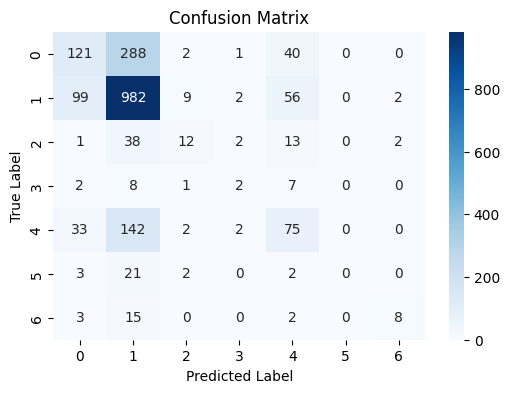

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Test Image Visualization

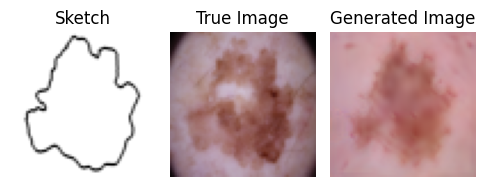

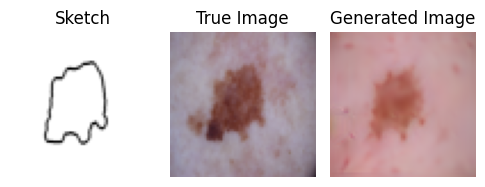

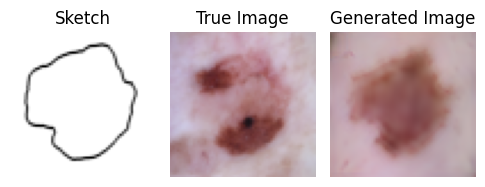

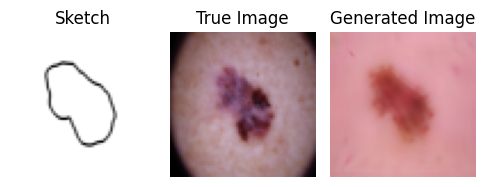

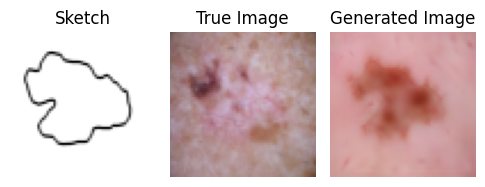

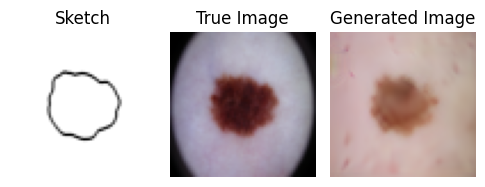

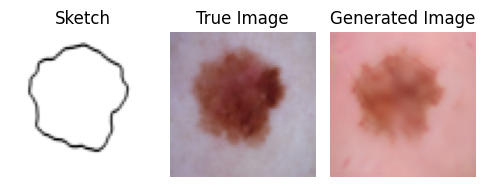

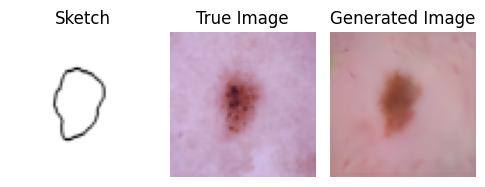

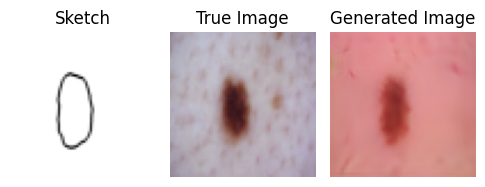

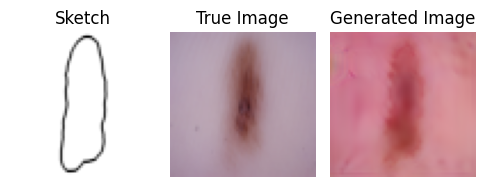

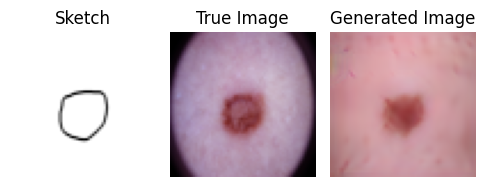

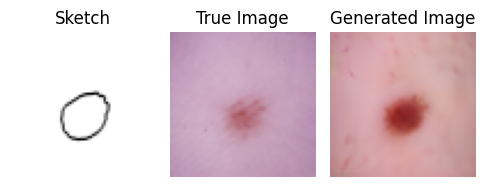

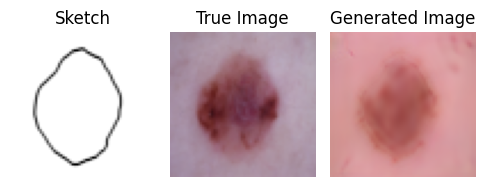

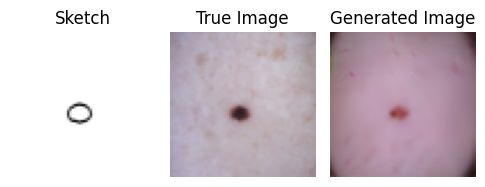

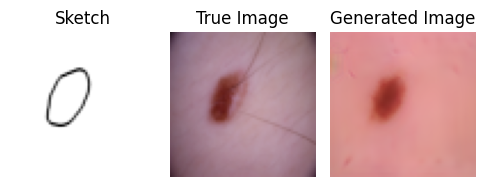

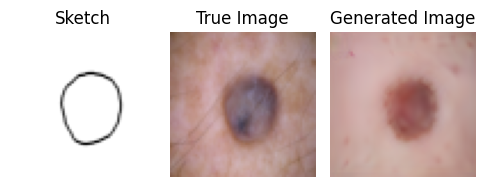

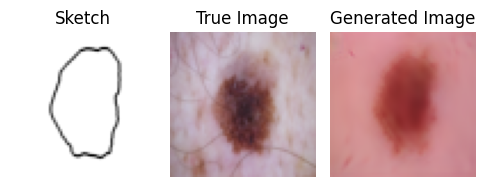

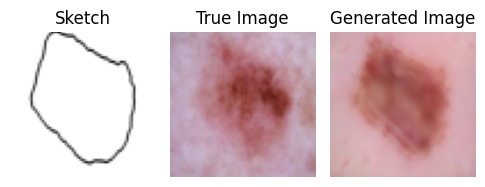

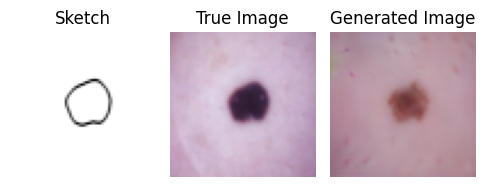

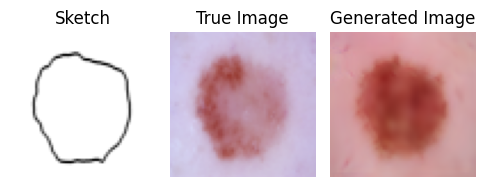

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to visualize sketches, true images, and corresponding generated images
def visualize_images(generator, test_data_loader, num_samples=20):
    # Set the generator to evaluation mode
    generator.eval()

    # Initialize a counter for the number of images printed
    num_printed = 0

    # Iterate over the first five samples in the test dataset
    for i, (real_images, sketches, true_labels, random_label_onehots, img_names, sketch_names) in enumerate(test_data_loader):
        if num_printed >= num_samples:
            break

        # Move data to the appropriate device
        sketches = sketches.to(device)
        real_images = real_images.to(device)
        true_labels = true_labels.to(device)

        # Generate images using the generator
        with torch.no_grad():
            generated_images = generator(sketches, true_labels).cpu().detach()  # Transfer to CPU

        # Visualize images
        for j in range(len(generated_images)):
            if num_printed >= num_samples:
                break

            fig, axes = plt.subplots(1, 3, figsize=(6, 4))  # Adjust the figure size here

            # Reduce spacing between subplots
            plt.subplots_adjust(wspace=0.1)  # Adjust the spacing as needed

            # Plot sketch
            sketch = sketches[j].permute(1, 2, 0).cpu().numpy()  # Transfer to CPU and convert to numpy
            axes[0].imshow(sketch, cmap='gray')  # Keep the sketch in grayscale
            axes[0].set_title("Sketch")
            axes[0].axis('off')

            # Plot true image
            true_image = real_images[j].permute(1, 2, 0).cpu().numpy()  # Transfer to CPU and convert to numpy
            axes[1].imshow(true_image)
            axes[1].set_title("True Image")
            axes[1].axis('off')

            # Plot generated image
            generated_image = generated_images[j].permute(1, 2, 0).numpy()  # Convert to numpy
            axes[2].imshow(generated_image)
            axes[2].set_title("Generated Image")
            axes[2].axis('off')

            plt.show()
            num_printed += 1

# Call the function to visualize images
visualize_images(generator, test_data_loader)


## Metrics

In [ ]:
n_channels = 1  # Number of input channels
n_classes = 7  # Number of output channels
bilinear = True  # Use bilinear interpolation for upsampling
generator = Generator(n_channels, n_classes, bilinear).to(device)

# Load the model checkpoint
checkpoint = torch.load('best_model(1).pth')

# Load the state dictionary of the generator
generator.load_state_dict(checkpoint)

# Set the generator to evaluation mode
generator.eval()


In [25]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor
import os
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate
from scipy.linalg import sqrtm
from torchvision.utils import make_grid
import torch
from torchvision.models import inception_v3
from torch.nn.functional import interpolate
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

### FID Score

In [26]:
import torch
from torchvision.models import inception_v3
from torch.nn.functional import interpolate
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


In [ ]:
# Generate images for evaluation
def generate_images(generator, sketches, labels):
    with torch.no_grad():
        # Move sketches and labels to CUDA
        sketches = sketches.cuda()
        labels = labels.cuda()

        # Generate images
        generated_images = generator(sketches, labels).cpu()

    return generated_images

# Compute Frechet Inception Distance (FID)
def calculate_fid(real_images, generated_images, device, eps=1e-5):
    # Preprocess the images
    real_images = (real_images + 1) / 2
    generated_images = (generated_images + 1) / 2

    # Extract features using Inception v3
    inception_model = inception_v3(pretrained=True).to(device).eval()

    real_features = []
    generated_features = []

    for real_image, generated_image in zip(real_images, generated_images):
        real_image = real_image.unsqueeze(0).to(device)
        generated_image = generated_image.unsqueeze(0).to(device)

        real_feature = inception_model(interpolate(real_image, size=(299, 299), mode='bilinear', align_corners=False))[0].view(-1)
        generated_feature = inception_model(interpolate(generated_image, size=(299, 299), mode='bilinear', align_corners=False))[0].view(-1)

        real_features.append(real_feature.detach().cpu().numpy())
        generated_features.append(generated_feature.detach().cpu().numpy())

    real_features = np.stack(real_features, axis=0)
    generated_features = np.stack(generated_features, axis=0)

    # Compute the FID
    real_mu, real_sigma = real_features.mean(axis=0), np.cov(real_features, rowvar=False) + eps * np.eye(real_features.shape[1])
    generated_mu, generated_sigma = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False) + eps * np.eye(generated_features.shape[1])

    fid = np.linalg.norm(real_mu - generated_mu) ** 2 + np.trace(real_sigma + generated_sigma - 2 * sqrtm(real_sigma @ generated_sigma))

    return fid.item()

# Example usage
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fid_scores = []

for i, (image, sketch, true_label, random_label, img_name, sketch_name) in enumerate(test_data_loader):
    # Move image and sketch to CUDA
    image, sketch = image.cuda(), sketch.cuda()

    # Generate images for the batch
    generated_images = generate_images(generator, sketch, true_label)

    # Compute FID score
    fid_score = calculate_fid(image, generated_images, device)
    fid_scores.append(fid_score)

print("Average FID score:", np.mean(fid_scores))

/tmp/ipykernel_7689/2392190678.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = torch.tensor(self.labels.iloc[idx, 1:], dtype=torch.float32)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date

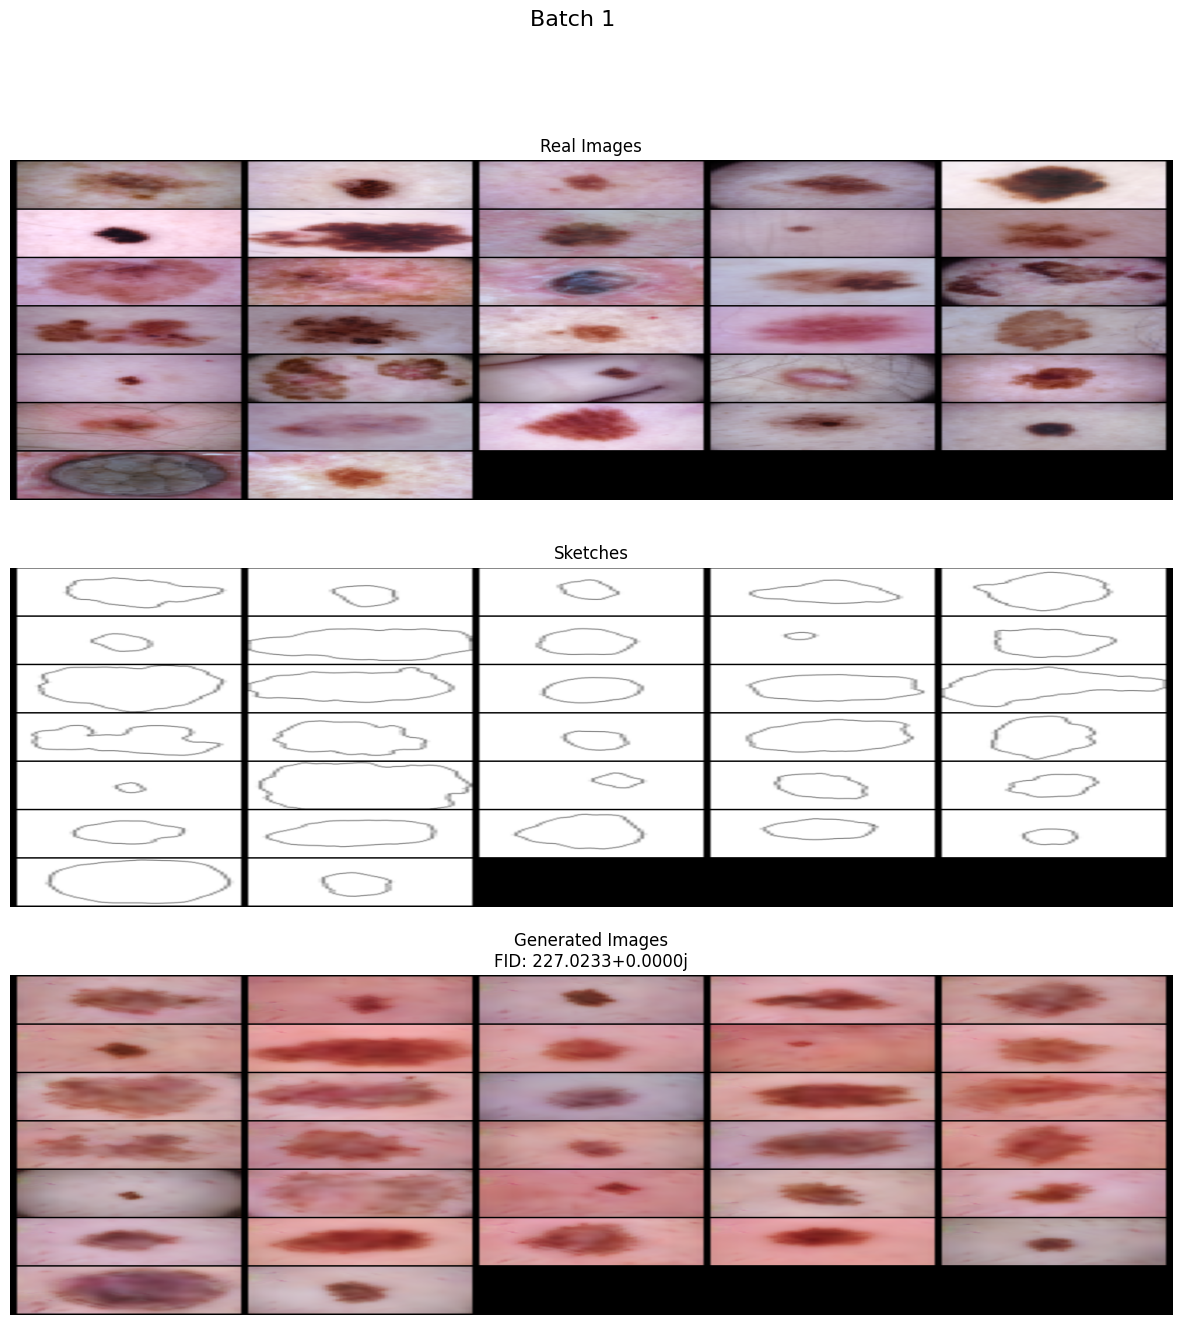

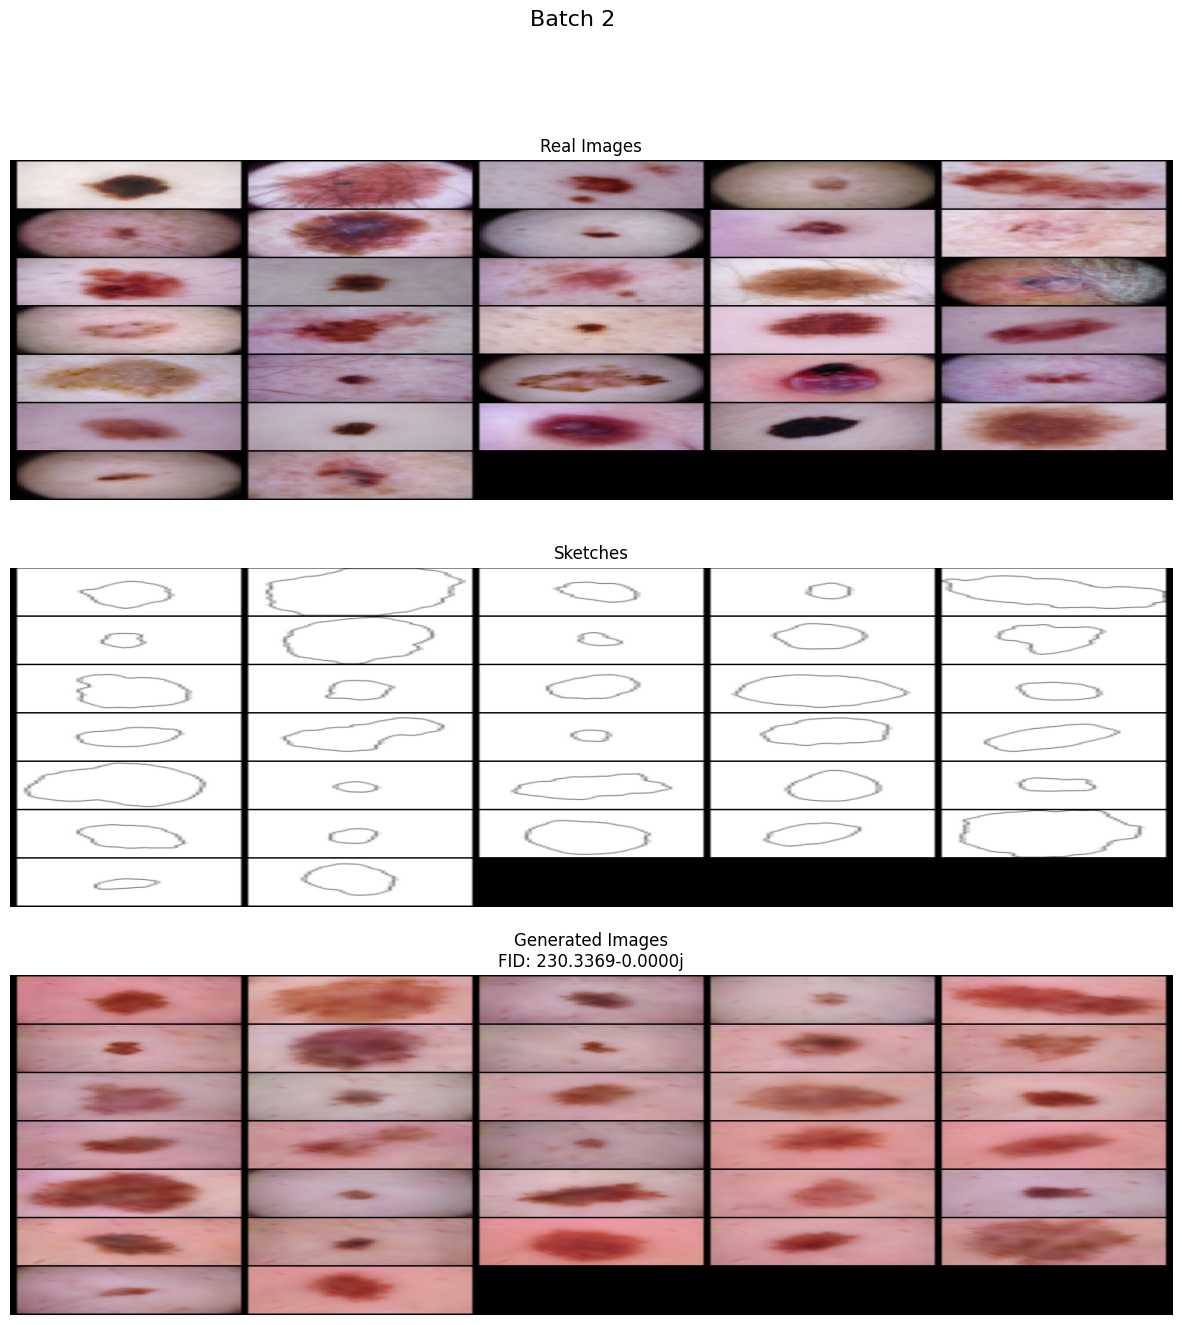

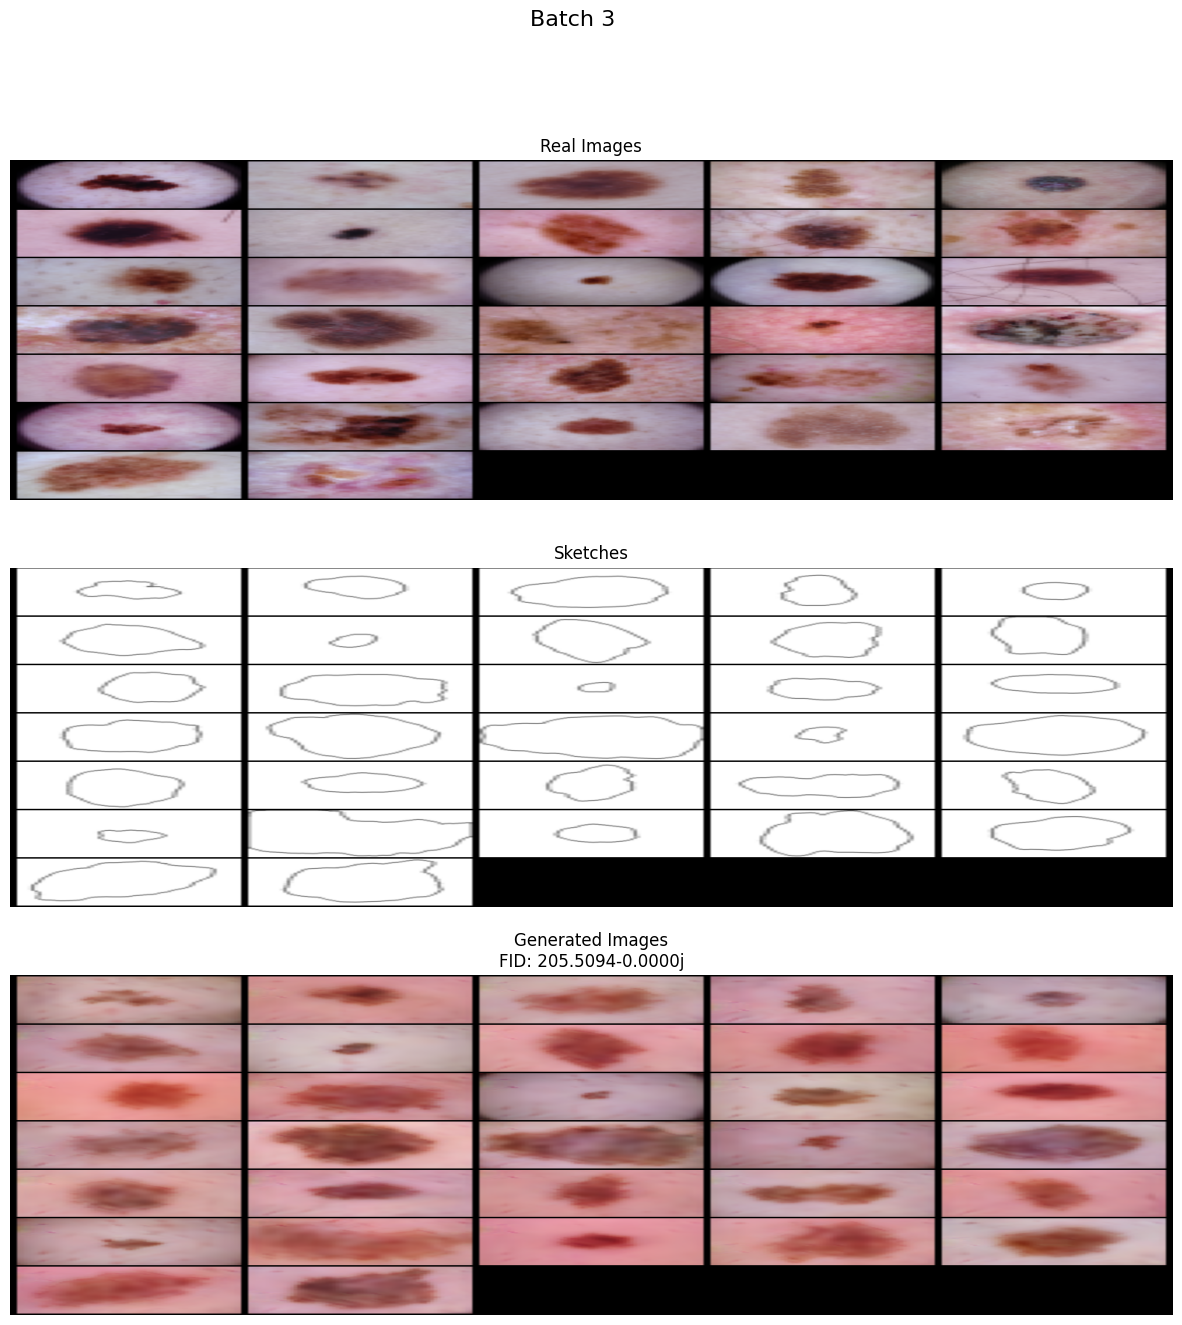

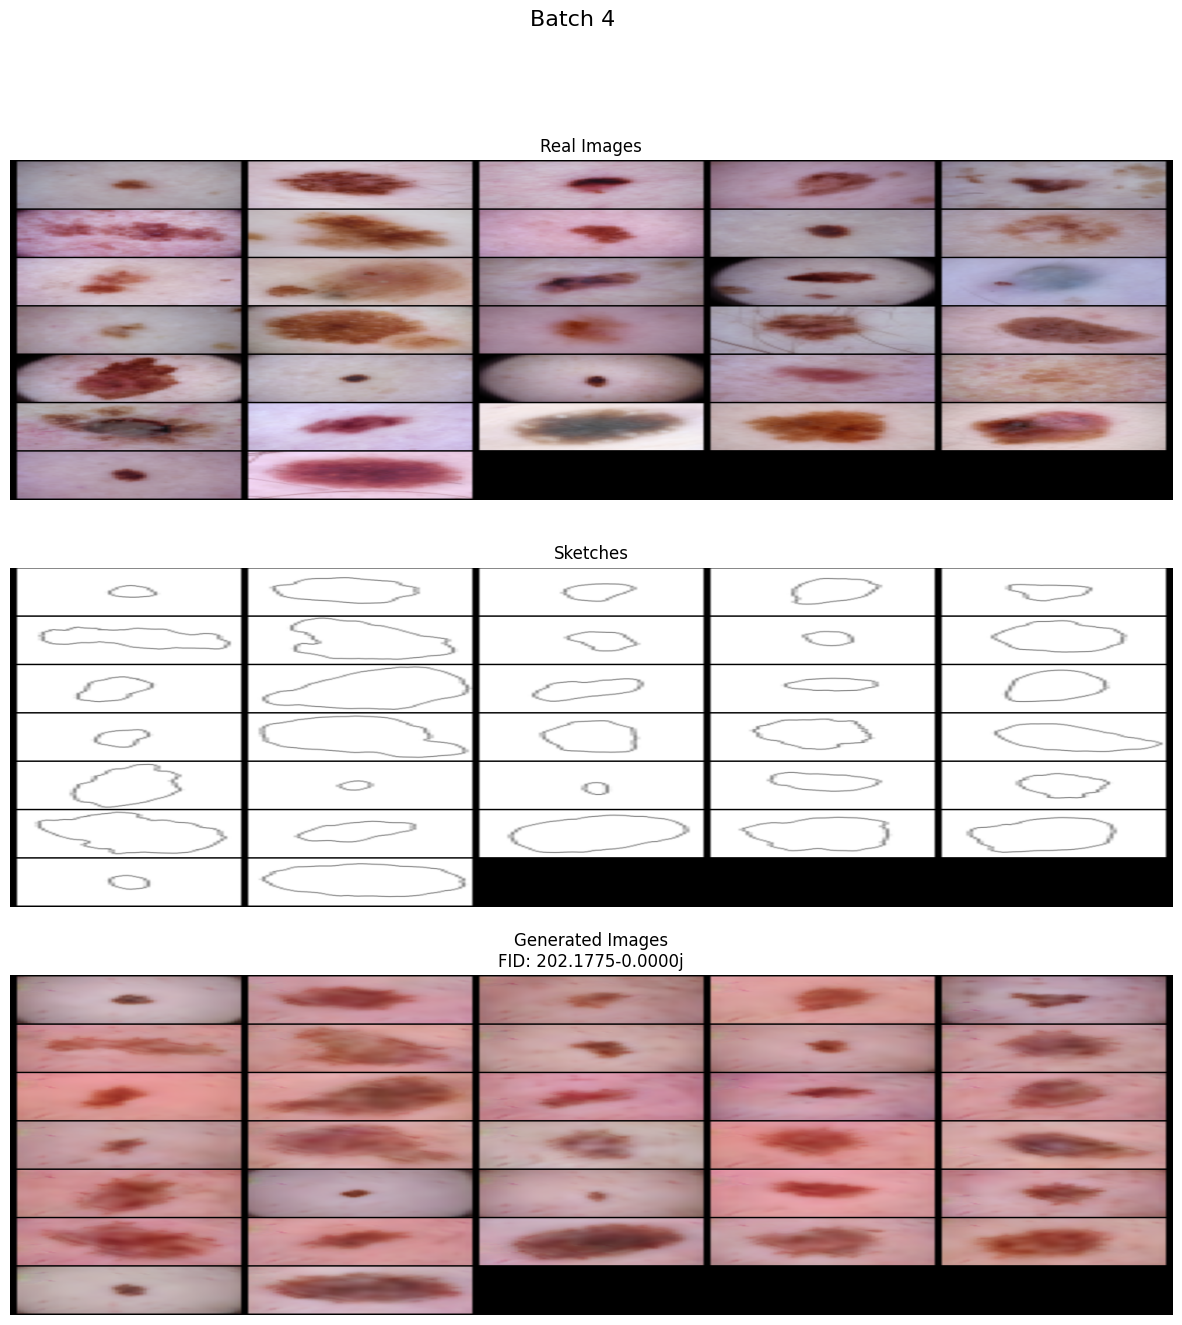

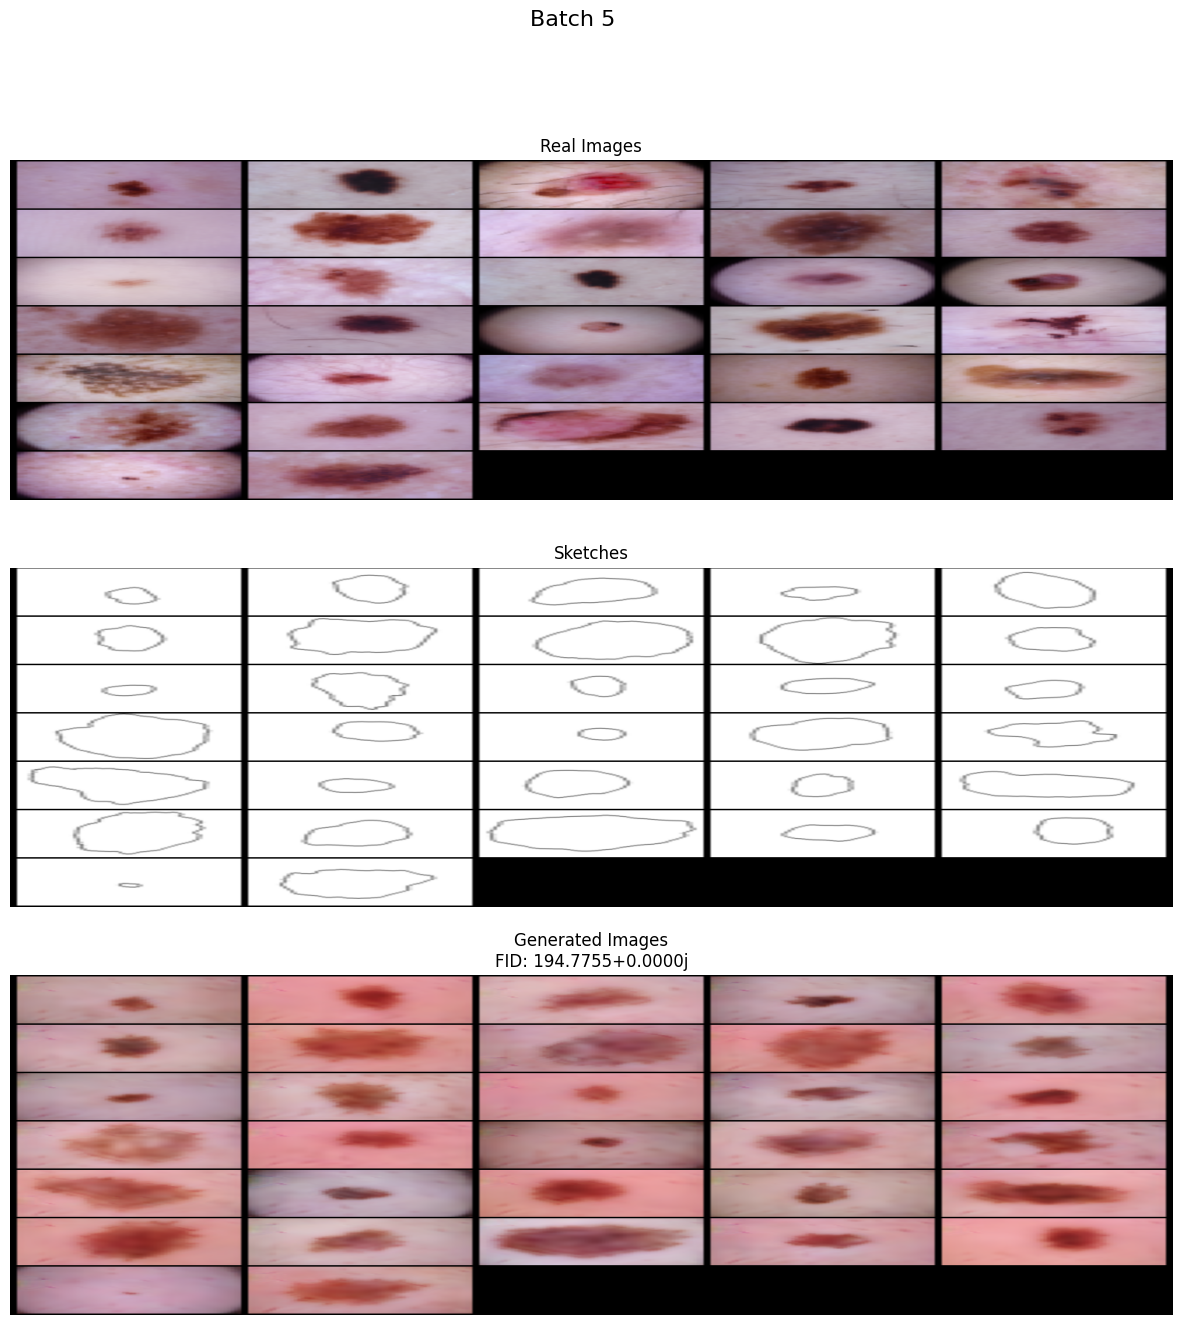

In [ ]:
# Visualize the first 5 batches
for i, (image, sketch, true_label, random_label, img_name, sketch_name) in enumerate(test_data_loader):
    if i < 5:
        # Move image and sketch to CPU
        image, sketch = image.cpu(), sketch.cpu()

        # Generate images for the batch
        generated_images = generate_images(generator, sketch, true_label)

        plt.figure(figsize=(15, 15))

        # Real images
        plt.subplot(3, 1, 1)
        grid = make_grid(image, nrow=5, padding=2, scale_each=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title('Real Images')
        plt.gca().set_aspect('auto')

        # Sketches
        plt.subplot(3, 1, 2)
        grid = make_grid(sketch, nrow=5, padding=2, scale_each=True)
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title('Sketches')
        plt.gca().set_aspect('auto')

        # Generated images
        plt.subplot(3, 1, 3)
        grid = make_grid(generated_images.cpu(), nrow=5, padding=2, scale_each=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"Generated Images\nFID: {fid_scores[i]:.4f}")
        plt.gca().set_aspect('auto')

        plt.suptitle(f"Batch {i+1}", fontsize=16)
        plt.show()

### Inception Score

In [ ]:
def calculate_inception_score(generator, data_loader, inception_model, device):
    all_preds = []
    generator.eval()
    transform = transforms.Resize((299, 299))
    to_tensor = transforms.ToTensor()

    with torch.no_grad():
        for images, sketches, true_labels, random_label_onehot, img_names, sketch_names in tqdm(data_loader):
            images = images.to(device)
            sketches = sketches.to(device)
            random_label_onehot = random_label_onehot.to(device)

            generated_images = generator(sketches, random_label_onehot).detach()
            resized_images = torch.stack([transform(img) for img in generated_images])
            resized_images = resized_images.to(device)

            preds = torch.softmax(inception_model(resized_images), dim=1)
            all_preds.append(preds)

    all_preds = torch.cat(all_preds, dim=0)
    mean_preds = torch.mean(all_preds, dim=0, keepdim=True).repeat(all_preds.size(0), 1)
    kl_divs = F.kl_div(all_preds.log(), mean_preds, reduction='batchmean')
    inception_score = torch.exp(kl_divs).item()

    return inception_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained Inception model for Inception Score calculation
inception_model = torchvision.models.inception_v3(pretrained=True, aux_logits=True)
inception_model.eval()
inception_model = inception_model.to(device)

# Number of iterations
num_iterations = 5

# List to store individual Inception Scores
inception_scores = []

for _ in range(num_iterations):
    # Generate images on test sketches and calculate Inception Score
    with torch.no_grad():
        test_inception_score = calculate_inception_score(generator, test_data_loader, inception_model, device)
    inception_scores.append(test_inception_score)

mean_score = np.mean(inception_scores)
std_score = np.std(inception_scores)

print(f'Mean Inception Score: {mean_score}')
print(f'Standard Deviation of Inception Score: {std_score}')


/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 200/200 [00:20<00:00,  9.68it/s]

Mean Inception Score: 1.4465659856796265
Standard Deviation of Inception Score: 0.0016152629023674608
